In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

In [46]:
%config InlineBackend.figure_format = "retina"

In [47]:
rf = 0.05
pri_r = 0.1
A_riesgo = 3

In [219]:
port_path = "Prueba.xlsx"
acciones = ["ASURB MF Equity", "BIMBOA MF Equity", "CEMEXCPO MF Equity", "ALSEA* MF Equity", "PE&OLES* MF Equity", "WALMEX* MF Equity", "GENTERA* MF Equity"]
data = pd.read_excel(port_path, index_col=0)[acciones + ["MEXBOL INDEX"]]
data.columns = [col.replace(" MF Equity", "") for col in data.columns]
rend = data.pct_change().dropna()

# 1.a Rendimiento promedio diario

In [220]:
rend.mean()[:-1]

ASURB       0.000490
BIMBOA     -0.000132
CEMEXCPO    0.000020
ALSEA*     -0.000019
PE&OLES*    0.000441
WALMEX*     0.000327
GENTERA*   -0.000284
dtype: float64

# 1.a Rendimiento promedio anual

In [221]:
rend.mean()[:-1] * 252

ASURB       0.123539
BIMBOA     -0.033289
CEMEXCPO    0.005054
ALSEA*     -0.004718
PE&OLES*    0.111053
WALMEX*     0.082426
GENTERA*   -0.071630
dtype: float64

In [222]:
Phi = rend.iloc[:, :-1].values
t = rend.iloc[:, [-1]]
N, M = Phi.shape

I = np.concatenate([np.identity(M)] * 2, axis=1)
I = np.concatenate([I] * 2, axis=0)

P = np.ones((N, M))
P = np.c_[P, Phi]

In [223]:
W = np.linalg.inv((P.T @ P) * I) @ P.T @ t
W["security"]  = np.concatenate([rend.columns[:-1]] * 2)
W["param"] = ["alpha"] * M + ["beta"] * M
B = W.pivot_table(index="security", columns="param", values="MEXBOL INDEX")

# 1.b Rendimiento CAPM diario

In [225]:
(rf + B["beta"] * pri_r) / 252

security
ALSEA*      0.000296
ASURB       0.000313
BIMBOA      0.000307
CEMEXCPO    0.000298
GENTERA*    0.000265
PE&OLES*    0.000251
WALMEX*     0.000314
Name: beta, dtype: float64

# 1.b Rendimiento CAPM anual

In [226]:
rf + B["beta"] * pri_r

security
ALSEA*      0.074710
ASURB       0.078961
BIMBOA      0.077345
CEMEXCPO    0.075109
GENTERA*    0.066750
PE&OLES*    0.063276
WALMEX*     0.079112
Name: beta, dtype: float64

# 1.b.i Betas

In [227]:
B["beta"]

security
ALSEA*      0.247096
ASURB       0.289610
BIMBOA      0.273451
CEMEXCPO    0.251091
GENTERA*    0.167495
PE&OLES*    0.132759
WALMEX*     0.291118
Name: beta, dtype: float64

# 1.b.ii Defensivas y agresivas

Todas las acciones son defensivas, debido a que su beta es menor a 1 (su variación respecto al mercado es acotada)

# 2. Matriz varianza y covarianza

In [228]:
rend = rend.iloc[:,:-1]
rend.cov()

,ASURB,BIMBOA,CEMEXCPO,ALSEA*,PE&OLES*,WALMEX*,GENTERA*
ASURB,0.000224,0.000052,0.000085,0.000053,0.000061,0.000036,0.000068
BIMBOA,0.000052,0.000237,0.000079,0.000064,0.000088,0.000049,0.000070
CEMEXCPO,0.000085,0.000079,0.000411,0.000064,0.000101,0.000048,0.000110
ALSEA*,0.000053,0.000064,0.000064,0.000235,0.000044,0.000057,0.000084
PE&OLES*,0.000061,0.000088,0.000101,0.000044,0.000548,0.000041,0.000088
WALMEX*,0.000036,0.000049,0.000048,0.000057,0.000041,0.000215,0.000063
GENTERA*,0.000068,0.000070,0.000110,0.000084,0.000088,0.000063,0.000425


In [229]:
def port_rend(weights, r):
    E_p = (r.mean() @ weights) * 252
    return E_p

def port_vol(weights, r):
    S_p = np.sqrt(weights.T @ (r.cov() * 252) @ weights)
    return S_p

In [230]:
weights_sim = np.random.random((5000, rend.shape[1]))
weights_sim = weights_sim / weights_sim.sum(axis=1, keepdims=True)

rend_sim = np.apply_along_axis(port_rend, 1, weights_sim, r=rend)
vol_sim = np.apply_along_axis(port_vol, 1, weights_sim, r=rend)

In [231]:
N, M = rend.shape
w0  = np.random.randn(M)
w0 = w0 / w0.sum()

def sum_weights(weights):
    return weights.sum() - 1 # == 0

def rend_esperado(w, E):
    return port_rend(w, rend) - E # == 0

constraints = [
    {"type": "eq", "fun": sum_weights}
]

port0 = minimize(port_vol, w0, constraints=constraints, args=rend)
wp0 = port0.x

# 3. Frontera de mínima varianza

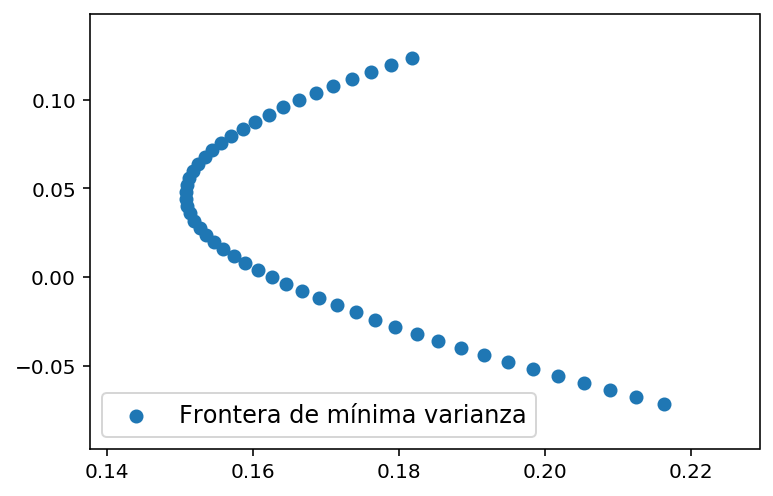

In [232]:
rend_ports = rend.mean() * 252
r_min = rend_ports.min()
r_max = rend_ports.max()

rend_max = np.linspace(r_min, r_max)

pesos_optimos = []
for e in rend_max:
    constraints = [
        {"type": "eq", "fun": sum_weights},
        {"type": "eq", "fun": lambda w: rend_esperado(w, e)}
    ]

    port1 = minimize(port_vol, w0, constraints=constraints, args=rend)
    w_opt = port1.x
    pesos_optimos.append(w_opt)

r_opt = []
v_opt = []
for w in pesos_optimos:
    r_opt.append(port_rend(w, rend))
    v_opt.append(port_vol(w, rend))

r_opt = np.array(r_opt)
v_opt = np.array(v_opt)

plt.scatter(v_opt, r_opt, label="Frontera de mínima varianza");
plt.legend(fontsize=12);

# 3. Frontera eficiente

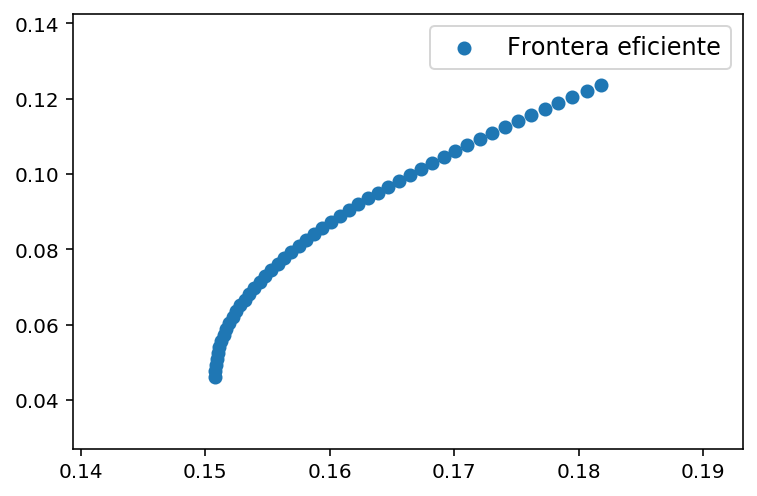

In [233]:
rend_ports = rend.mean() * 252
r_min = port_rend(wp0, rend)
r_max = rend_ports.max()

rend_max = np.linspace(r_min, r_max)

pesos_optimos = []
for e in rend_max:
    constraints = [
        {"type": "eq", "fun": sum_weights},
        {"type": "eq", "fun": lambda w: rend_esperado(w, e)}
    ]

    port1 = minimize(port_vol, w0, constraints=constraints, args=rend)
    w_opt = port1.x
    pesos_optimos.append(w_opt)

r_opt = []
v_opt = []
for w in pesos_optimos:
    r_opt.append(port_rend(w, rend))
    v_opt.append(port_vol(w, rend))

r_opt = np.array(r_opt)
v_opt = np.array(v_opt)

plt.scatter(v_opt, r_opt, label="Frontera eficiente");
plt.legend(fontsize=12);

In [234]:
def min_func_sharpe(weights):
    return - (port_rend(weights, rend) - rf) / port_vol(weights, rend)

constraints = [
    {"type": "eq", "fun": sum_weights},
    {"type": "ineq", "fun": lambda w: -rend_esperado(w, r_max)}
]

f_sharpe = minimize(min_func_sharpe, w0, constraints=constraints)

# 4. Portafolio riesgoso óptimo

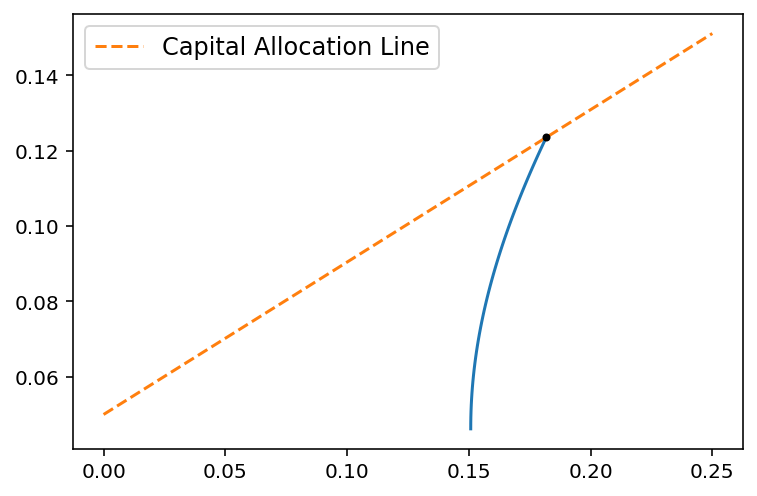

In [235]:
w_sharpe = f_sharpe.x
e_sharpe = port_rend(w_sharpe, rend)
vol_sharpe = port_vol(w_sharpe, rend)

sigma_c =  np.linspace(0, 0.25)
sharpe = rf + sigma_c * (e_sharpe - rf) / vol_sharpe

plt.plot(sigma_c, sharpe, linestyle="--", c="tab:orange", label="Capital Allocation Line");
plt.plot(v_opt, r_opt);
plt.plot([vol_sharpe], [e_sharpe], marker='o', markersize=3, color="black");
plt.legend(fontsize=12);

# 5. Portafolio riesgoso y activo libre de riesgo

In [238]:
y_star = (e_sharpe - rf) / (A_riesgo * vol_sharpe **2)
print(f"La proporción a invertir en el portafolio riesgoso es de {round(y_star * 100,2)}%")

La proporción a invertir en el portafolio riesgoso es de 74.18%


# 6. ¿En qué escenarios usarías una red neuronal?

Utilizaría una red neuronal en los siguientes escenarios:  
- Se dispone de mucha información  
- La precisión de los resultados es fundamental  
- Se dispone de poder computacional

# 7. ¿En qué escenarios no usarías una red neuronal?

No utilizaría una red neuronal en los siguientes escenarios:  
- Se dispone de información limitada  
- Se busca interpretar los resultados del modelo

# 8. Menciona tres funciones de activación para una red neuronal feed-forward

1) RELU  
2) Sigmoidal    
3) Gaussiana

# 9. ¿Qué es el método de backpropagation?

Algoritmo utilizado para ajustar los pesos de una red neuronal. Los ajustes se realizan mediante iteraciones que minimizan una función de error, comenzando en las últimas capas y yendo hacia atrás

# 10. ¿En qué difiere una red neuronal feed-forward de una red neuronal convolucional?

En una red neuronal feed forward las neuronas de una capa están conectadas secuencialmente a las neuronas de la siguiente capa. Las redes convolucionales son aquellas en las que se aplican filtros para capturar características específicas.